In [1]:
from casadi import *
from casadi.tools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import matplotlib
import pickle
import os

(0.0, 150.0)

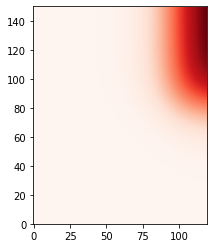

In [2]:
def spatialpenalty(x, k, mu, amp):
    return(amp/(1+np.exp(1+k*(x-mu)))) #why "1"+k(x-mu) shift

def speedpenalty(x, k, mu, amp):
    return(amp/(1+np.exp(1+k*(x-mu))))

xspace = linspace(0, 1.20, 120)
kspace = -10
muspace = 0.90
ampspace = 10

xspeed = linspace(0, 1.50, 150)
kspeed = -10
muspeed = 0.75
ampspeed = 10

yy, xx = np.meshgrid(spatialpenalty(xspace, kspace, muspace, ampspace), speedpenalty(xspeed, kspeed, muspeed, ampspeed))
plt.imshow(xx*yy, cmap='Reds')
plt.ylim(0, 150)

# Functions to estimate the optimal trajectory

In [3]:
def spatialpenalty(x, k, mu, amp):
    return(amp/(1+np.exp(1+k*(x-mu)))) #why "1"+k(x-mu) shift

def speedpenalty(x, k, mu, amp):
    return(amp/(1+np.exp(1+k*(x-mu))))

def optimal_trajectory(cost, a, b, xb, tf, Ltread, vtapis, tau_res, mass, ampxpenalty, kxpenalty, nk):
    """Compute the optimal trajectory
    Args:
        cost: string, cost type (defines the effort and spacial costs)  
        a: scalar, effort sensitivity 
        b: scalar, spacial sensitivity
        xb: scalar, beam location
        xi: scalar, initial position
        xf: scalar, final position
        tf: scalar, final time (entrance time)
        vtapis: scalar, treadmill speed
        tau_res: scalar, resistive force, tau
        mass: scalar, rat's weight (mass)
        ampxpenalty: scalar, height of the spatial penalty function
        kxpenalty: scalar, steepness of the spatial penalty function 
        nk: scalar, number of collocation points
    Returns:
        (x0_opt,x1_opt,tgrid,u_opt,tgrid_u,float(res["f"])): lists; optimal positions, optimal speeds
        time for postion and speed), optimal control, time for optimal control, final total cost."""
    
    #mu=0.1    # Control discretization
    #kT=mu/1
    
    # Declare variables
    t = SX.sym("t")    # time
    u = SX.sym("u")    # control

    states = struct_symSX([
            entry('x', shape=2),    #  states
            entry('L')             #  helper state: Langrange integrand
         ])

    # Create a structure for the right hand side
    rhs = struct_SX(states)
    x = states['x']
    #  rhs["x"] = vertcat(x[1],u)    
    rhs["x"] = vertcat(x[1], u - fabs(x[1]-vtapis)/tau_res)
 
    speedlimit = 0.75

    if cost=='speed':  
        rhs["L"] = a * mass * (x[1]-vtapis)**2 #+ (b*spatialpenalty(x=x[0],k=kxpenalty,mu=xb,amp=ampxpenalty)*
                                               # speedpenalty(x=x[1],k=kxpenalty,mu=speedlimit,amp=ampxpenalty))
    elif cost=='force':   
         rhs["L"] = a * (mass * u)**2 #+ (b*spatialpenalty(x=x[0],k=kxpenalty,mu=xb,amp=ampxpenalty)*
        #                                         speedpenalty(x=x[1],k=kxpenalty,mu=speedlimit,amp=ampxpenalty))
    elif cost=='mixed':
        rhs["L"] = a * (mass) * fabs(u) * (x[1]-vtapis)
        #rhs["L"] = a*((mass*u)**2) * ((x[1]-vtapis)**2)  + (b*spatialpenalty(x=x[0],k=kxpenalty,mu=xb,amp=ampxpenalty)* speedpenalty(x=x[1],k=kxpenalty,mu=speedlimit,amp=ampxpenalty))

    # ODE right hand side function
    f = Function('f', [t, states, u], [rhs])

    # Objective function (meyer term)
    m = Function('m', [t, states, u], [states["L"]])

    # Control bounds
    u_min = -1.5
    u_max = 2.5
    u_init = 0.0

    u_lb = np.array([u_min])
    u_ub = np.array([u_max])
    u_init = np.array([u_init])

    # State bounds and initial guess
    vmax = 1.5
    x_min  = [0, 0, -inf]
    x_max  = [xb, vmax - vtapis, inf]
    xi_min = [0, 0, 0]
    xi_max = [0, 0, inf]
    xf_min = [xb, 0, -inf]
    xf_max = [xb, 0,  inf]
    x_init = [0, 0, 0]

    # Dimensions
    nx = 3
    nu = 1

    # Choose collocation points
    tau_root = [0] + collocation_points(3, "radau")

    # Degree of interpolating polynomial
    d = len(tau_root)-1

    # Size of the finite elements
    h = tf/nk

    # Coefficients of the collocation equation
    C = np.zeros((d+1,d+1))

    # Coefficients of the continuity equation
    D = np.zeros(d+1)

    # Dimensionless time inside one control interval
    tau = SX.sym("tau")

    # All collocation time points
    T = np.zeros((nk,d+1))
    for k in range(nk):
        for j in range(d+1):
            T[k,j] = h*(k + tau_root[j])

    # For all collocation points
    for j in range(d+1):
    # Construct Lagrange polynomials to get the polynomial basis at the collocation point
        L = 1
        for r in range(d+1):
            if r != j:
                L *= (tau-tau_root[r])/(tau_root[j]-tau_root[r])

        # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
        lfcn = Function('lfcn', [tau],[L])
        D[j] = lfcn(1.0)

        # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
        tfcn = Function('tfcn', [tau], [tangent(L, tau)])
        for r in range(d+1):
            C[j,r] = tfcn(tau_root[r])

    # Structure holding NLP variables
    V = struct_symMX([
      (
       entry("X",repeat=[nk+1,d+1],struct=states),
       entry("U",repeat=[nk],shape=nu)
      )
    ])

    vars_lb   = V()
    vars_ub   = V()
    vars_init = V()

    # Set states and its bounds
    vars_init["X",:,:] = repeated(repeated(x_init))
    vars_lb["X",:,:]   = repeated(repeated(x_min))
    vars_ub["X",:,:]   = repeated(repeated(x_max))

    # Set controls and its bounds
    vars_init["U",:] = repeated(u_init)
    vars_lb["U",:]   = repeated(u_min)
    vars_ub["U",:]   = repeated(u_max)

    # State at initial time
    vars_lb["X",0,0] = xi_min
    vars_ub["X",0,0] = xi_max

    # State at end time
    vars_lb["X",-1,0] = xf_min
    vars_ub["X",-1,0] = xf_max

    # Constraint function for the NLP (Non Linear Program)
    g = []
    lbg = []
    ubg = []

    # For all finite elements
    for k in range(nk):

        # For all collocation points
        for j in range(1,d+1):

        # Get an expression for the state derivative at the collocation point
            xp_jk = 0
            for r in range (d+1):
                xp_jk += C[r,j]*V["X",k,r]

            # Add collocation equations to the NLP
            fk = f(T[k][j], V["X",k,j], V["U",k])
            g.append(h*fk - xp_jk)
            lbg.append(np.zeros(nx)) # equality constraints
            ubg.append(np.zeros(nx)) # equality constraints

        # Get an expression for the state at the end of the finite element
        xf_k = 0
        for r in range(d+1):
            xf_k += D[r]*V["X",k,r]

        # Add continuity equation to NLP
        g.append(V["X",k+1,0] - xf_k)
        lbg.append(np.zeros(nx))
        ubg.append(np.zeros(nx))

    # Concatenate constraints
    g = vertcat(*g)

    # Objective function
    f = m(T[nk-1][d],V["X",nk,0],V["U",nk-1])

    # NLP
    nlp = {'x':V, 'f':f, 'g':g}

    ## ----
    ## SOLVE THE NLP
    ## ----

    # Set options
    opts = {}
    opts["expand"] = True
    #opts["ipopt.max_iter"] = 4

    # Allocate an NLP solver
    solver = nlpsol("solver", "ipopt", nlp, opts)
    arg = {}

    # Initial condition
    arg["x0"] = vars_init

    # Bounds on x
    arg["lbx"] = vars_lb
    arg["ubx"] = vars_ub

    # Bounds on g
    arg["lbg"] = np.concatenate(lbg)
    arg["ubg"] = np.concatenate(ubg)

    # Solve the problem
    res = solver(**arg)

    # Print the optimal cost
    print("optimal cost: ", float(res["f"]))

    # Retrieve the solution
    opt = V(res["x"])

    # Get values at the beginning of each finite element
    x0_opt = opt["X",:,0,"x",0]
    x1_opt = opt["X",:,0,"x",1]
    x2_opt = opt["X",:,0,"L"]

    u_opt = opt["U",:,0]

    tgrid = np.linspace(0,tf,nk+1)
    tgrid_u = np.linspace(0,tf,nk)
            #x   , xdotk, tk  , acck,  tak  , oc  
    return(x0_opt,x1_opt,tgrid,u_opt,tgrid_u,float(res["f"]))


# Computations 









### Variable Effort Sensitivity:
- Spatial Penalty: Heaviside Diffuse/Localized 
- Effort: Kinetic energy, Force

In [7]:
results_folder = 'PickleResults/Simulations'
if not os.path.exists(results_folder): os.makedirs(results_folder)
#kxpenalty_list = [1,100]  # steepness of penalty cost (the higher the steeper: 100 very steep, 1 very diffused)
file_to_save_name_list = [results_folder + '/DiffuseHeavisideSpatialCostEffort.pickle', 
                          results_folder + '/SteepHeavisideSpatialCostEffort.pickle']
Ltread = .90
ampxpenalty = 10.0
kxpenalty = -10.0
xb = Ltread - 0.20
tf = 1.6     # final time (duration of experiment)
vtapis_list = [0]  # [-0.2, -0.1, -0.02, 0.02, 0.1, 0.2]
# tf_list = [1.0, 2.0, 3.0, 4.0]
xb_list = [0.6, 0.9, 1.2]
mass = 0.4
tau_res = 1.8 # like humans, or following vector [.9, 1.8, 3.6]
nk = 300 # this is too slow with 500 collocation points
n_comb = len(xb_list)
a_list = 1.


In [8]:
# speed 
xk_vect_speed_heav = np.zeros((nk+1,n_comb))
xdotk_vect_speed_heav = np.zeros((nk+1,n_comb))
tk_vect_speed_heav = np.zeros((nk+1,n_comb))
acck_vect_speed_heav = np.zeros((nk,n_comb))
tak_vect_speed_heav = np.zeros((nk,n_comb))
oc_vect_speed_heav = np.zeros((1,n_comb))

# force
xk_vect_force_heav = np.zeros((nk+1,n_comb))
xdotk_vect_force_heav = np.zeros((nk+1,n_comb))
tk_vect_force_heav = np.zeros((nk+1,n_comb))
acck_vect_force_heav = np.zeros((nk,n_comb))
tak_vect_force_heav = np.zeros((nk,n_comb))
oc_vect_force_heav = np.zeros((1,n_comb))

# mixed
xk_vect_mixed_heav = np.zeros((nk+1,n_comb))
xdotk_vect_mixed_heav = np.zeros((nk+1,n_comb))
tk_vect_mixed_heav = np.zeros((nk+1,n_comb))
acck_vect_mixed_heav = np.zeros((nk,n_comb))
tak_vect_mixed_heav = np.zeros((nk,n_comb))
oc_vect_mixed_heav = np.zeros((1,n_comb))

for ic in range(len(xb_list)):
    print("ic is " + str(ic))
    xb = xb_list[ic]
    tf = 2
    vtapis = 0  # vtapis_list[ic]
    #ic = 0
    b=0
    ###############################################

    xk,xdotk,tk,acck,tak,oc = optimal_trajectory(cost='speed', a=a_list, b=b, xb=xb, tf=tf, Ltread=Ltread,
                                                    vtapis=vtapis, tau_res=tau_res, mass=mass,
                                                    ampxpenalty = ampxpenalty, kxpenalty = kxpenalty,
                                                    nk=nk)
    xk_vect_speed_heav[:,ic] = xk
    xdotk_vect_speed_heav[:,ic] = xdotk
    tk_vect_speed_heav[:,ic] = tk
    acck_vect_speed_heav[:,ic] = acck
    tak_vect_speed_heav[:,ic] = tak    
    oc_vect_speed_heav[:,ic] = oc     

    ###############################################

    xk,xdotk,tk,acck,tak,oc = optimal_trajectory(cost='force', a=a_list, b=b, xb=xb, tf=tf, Ltread=Ltread,
                                                    vtapis=vtapis, tau_res=tau_res, mass=mass,
                                                    ampxpenalty = ampxpenalty, kxpenalty = kxpenalty,
                                                    nk=nk)   
    xk_vect_force_heav[:,ic] = xk
    xdotk_vect_force_heav[:,ic] = xdotk
    tk_vect_force_heav[:,ic] = tk
    acck_vect_force_heav[:,ic] = acck
    tak_vect_force_heav[:,ic] = tak    
    oc_vect_force_heav[:,ic] = oc 


    ###############################################

    # xk,xdotk,tk,acck,tak,oc = optimal_trajectory(cost='mixed', a=a_list, b=b, xb=xb, tf=tf, Ltread=Ltread,
    #                                                 vtapis=vtapis, tau_res=tau_res, mass=mass,
    #                                                 ampxpenalty = ampxpenalty, kxpenalty = kxpenalty,
    #                                                 nk=nk)     
    # xk_vect_mixed_heav[:,ic] = xk
    # xdotk_vect_mixed_heav[:,ic] = xdotk
    # tk_vect_mixed_heav[:,ic] = tk
    # acck_vect_mixed_heav[:,ic] = acck
    # tak_vect_mixed_heav[:,ic] = tak    
    # oc_vect_mixed_heav[:,ic] = oc 

###############################################
###############################################    
file_to_save_name = file_to_save_name_list[0]
results = {}
for i in ('xk_vect_speed_heav','xdotk_vect_speed_heav', 'tk_vect_speed_heav',
            'acck_vect_speed_heav','tak_vect_speed_heav','oc_vect_speed_heav',
            'xk_vect_force_heav','xdotk_vect_force_heav', 'tk_vect_force_heav',
            'acck_vect_force_heav','tak_vect_force_heav','oc_vect_force_heav'):
    results[i] = locals()[i]                    

with open(file_to_save_name, 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

ic is 0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    15292
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      900

Total number of variables............................:     3908
                     variables with only lower bounds:        1
                variables with lower and upper bounds:     2704
                     variables with only upper bounds:        0
Total number

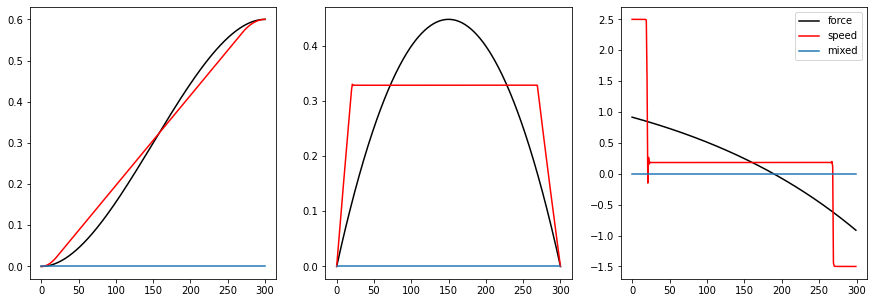

In [9]:
fig = plt.figure(constrained_layout = False, figsize=(15, 5))
gs = fig.add_gridspec(1, 3)
ax00 = fig.add_subplot(gs[0, 0])
ax00.plot(xk_vect_force_heav[:,0], label = 'force', color='k')
ax00.plot(xk_vect_speed_heav[:,0], label = 'speed', color='r')
ax00.plot(xk_vect_mixed_heav[:,0], label = 'mixed')

ax01 = fig.add_subplot(gs[0, 1])
ax01.plot(xdotk_vect_force_heav[:,0], label = 'force', color='k')
ax01.plot(xdotk_vect_speed_heav[:,0], label = 'speed', color ='r')
ax01.plot(xdotk_vect_mixed_heav[:,0], label = 'mixed')

ax02 = fig.add_subplot(gs[0, 2])
ax02.plot(acck_vect_force_heav[:,0], label = 'force', color='k')
ax02.plot(acck_vect_speed_heav[:,0], label = 'speed', color='r')
ax02.plot(acck_vect_mixed_heav[:,0], label = 'mixed')

plt.legend()

In [10]:
v = xdotk
u = acck
print(mass * np.dot(v,v))
print(mass**2 * np.dot(u,u))
print(np.sum(copt))
len(v)

51.97743342312762
58.36240286650026


NameError: name 'copt' is not defined

In [11]:
fig = plt.figure(constrained_layout = False, figsize=(15, 5))
gs = fig.add_gridspec(1, 3)
for ic in range(len(tf_list)):
    ax00 = fig.add_subplot(gs[0, 0])
    ax00.plot(tk_vect_speed_heav[:,ic],xk_vect_force_heav[:,ic], label = 'force', color='k')
    ax00.plot(tk_vect_speed_heav[:,ic],xk_vect_speed_heav[:,ic], label = 'speed', color='r')
    # ax00.plot(xk_vect_mixed_heav[:,ic], label = 'mixed')


    ax01 = fig.add_subplot(gs[0, 1])
    ax01.plot(tk_vect_speed_heav[:,ic],xdotk_vect_force_heav[:,ic], label = 'force', color='k')
    ax01.plot(tk_vect_speed_heav[:,ic],xdotk_vect_speed_heav[:,ic], label = 'speed', color ='r')
    # ax01.plot(xdotk_vect_mixed_heav[:,ic], label = 'mixed')

    # ax02 = fig.add_subplot(gs[0, 2])
    # ax02.plot(acck_vect_force_heav[:,ic], label = 'force', color='k')
    # ax02.plot(acck_vect_speed_heav[:,ic], label = 'speed', color='r')
    # ax02.plot(acck_vect_mixed_heav[:,ic], label = 'mixed')

    # plt.legend()

NameError: name 'tf_list' is not defined

<Figure size 1080x360 with 0 Axes>

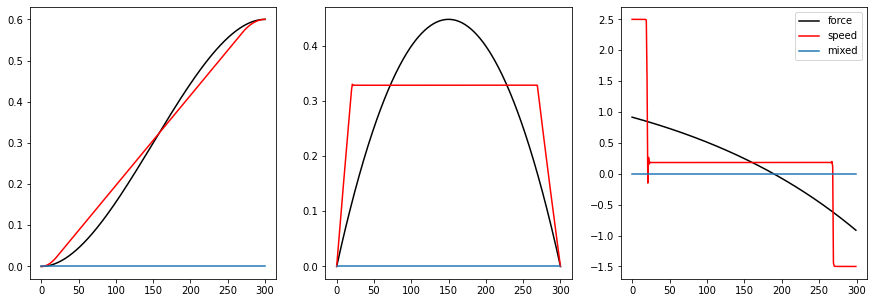

In [12]:
fig = plt.figure(constrained_layout = False, figsize=(15, 5))
gs = fig.add_gridspec(1, 3)
ax00 = fig.add_subplot(gs[0, 0])
ax00.plot(xk_vect_force_heav[:,0], label = 'force', color='k')
ax00.plot(xk_vect_speed_heav[:,0], label = 'speed', color='r')
ax00.plot(xk_vect_mixed_heav[:,0], label = 'mixed')

ax01 = fig.add_subplot(gs[0, 1])
ax01.plot(xdotk_vect_force_heav[:,0], label = 'force', color='k')
ax01.plot(xdotk_vect_speed_heav[:,0], label = 'speed', color ='r')
ax01.plot(xdotk_vect_mixed_heav[:,0], label = 'mixed')

ax02 = fig.add_subplot(gs[0, 2])
ax02.plot(acck_vect_force_heav[:,0], label = 'force', color='k')
ax02.plot(acck_vect_speed_heav[:,0], label = 'speed', color='r')
ax02.plot(acck_vect_mixed_heav[:,0], label = 'mixed')

plt.legend()